# Voorbewerking
Voor tijdreeksanalyse zijn grondwaterstanden en verklarende reeksen nodig. Beide komen in verschillende lengtes, frequenties en kwaliteit. In veel gevallen is een voorbewerking van de reeksen nodig. In dit notebook wordt geïllustreerd welke bewerkingen je kan doen en wanneer deze nodig zijn.  Onderstaande voorbeelden worden uitgewerkt: 



**Inhoudsopgave**


- [Opschonen stijghoogte reeks](#Opschonen-stijghoogte-reeks)
- [Vereenvoudigen stijghoogte reeks](#Vereenvoudigen-stijghoogte-reeks)
- [Equidistant maken verklarende reeks](#Equidistant-maken-verklarende-reeks)
- [Opvullen verklarende reeks](#Opvullen-verklarende-reeks)
- [Synchroniseren verklarende reeks](#Synchroniseren-verklarende-reeks)
- [Normaliseren peil](#Normaliseren-peil)
- [Eenheden afstemmen](#Eenheden-afstemmen)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

from matplotlib.gridspec import GridSpec

ps.set_log_level("ERROR")
#ps.show_versions()
%config InlineBackend.figure_format = 'svg'

## Opschonen stijghoogte reeks
Het doel van tijdreeksanalyse is een grondwaterstands of stijghoogte reeks te verklaren uit invoerreeksen. Door middel van automatische optimalisatie probeert de software de reeks zo dicht mogelijk te benaderen. Wanneer er fouten in de reeks aanwezig zijn kan dat grote gevolgen hebben voor de kwaliteit van het model. 
Onderstaand voorbeeld geeft een model dat is geoptimaliseerd zonder een duidelijke uitbijter te verwijderen. 

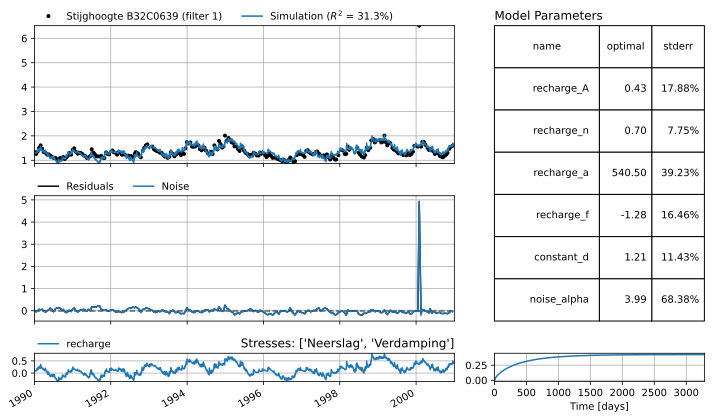

In [2]:
# Read data
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"
head = pd.read_csv("data/B32C0639001_changed.csv",  parse_dates=['date'], index_col='date', squeeze=True)
head.name = "Stijghoogte B32C0639 (filter 1)"

# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(rm)

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()



De resultaten van dit model zijn niet erg bemoedigend. De verklaarde variantie bedraagt slechts 31%. Dit komt mede door de grote afwijking bij de uitbijter,  maar ook de standaard-fouten van de parameters zijn relatief groot en de responstijd van de neerslag en verdamping lijkt voor nederlandse begrippen aan de hoge kant.   
We gaan nu kijken wat de resultaten worden als we de uitbijter verwijderen. 

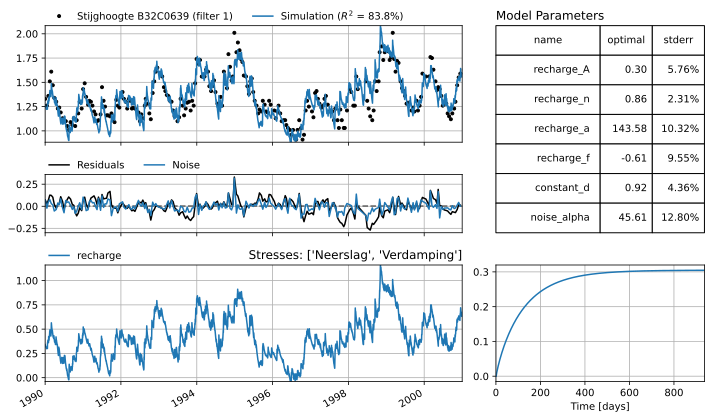

In [3]:
# remove outlier
head[head > 4] = np.nan

# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(rm)

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()


In bovenstaande figuur is te zien dat het model veel beter presteert met de opgeschoonde reeks. Het blijkt dat de uitbijter (ook als is het er maar één) een grote nvloed heeft op het resultaat. Naast een betere fit (84%), zijn ook de standaardfouten kleiner en is de respons korter geworden.     

## Vereenvoudigen stijghoogte reeks
Sommige reeksen bevatten zeer hoogfrequente data, met bijvoorbeeld een tijdstap van een uur of nog korter. Afhankelijk van het doel van de tijdreeksanalyse en de beschikbare invoer, kan het gewenst zijn om de reeksen te aggregeren of uit te dunnen. Hier geven we een voorbeeld van deze situatie. 

%% Voorbeeld van een hoogfrequente reeks (uurwaarden met getij), waar we een berekening doen met en zonder uitgedunde/geaggregeerde reeks


In [10]:
# Voorbeeld van een hoogfrequente reeks (uurwaarden met getij),
# waar we een berekening doen met en zonder uitgedunde/geaggregeerde reeks


## Equidistant maken verklarende reeks
Voor de meeste tijdreeksanalyseprogramma's is het nodig dat de verklarende reeksen gelijke tijdstappen hebben, ofwel equidistant zijn. Aan de hand van een praktijkvoorbeeld illustreren we hoe dat in zijn werk gaat.    

%% Voorbeeld onttrekkingsdata op maandbasis 

In [11]:
# Voorbeeld van Raoul met onttrekkingdsdata  

## Opvullen verklarende reeks
%% Voorbeeld met opvullen van onttrekkingsdata   (gemiddelde ervoor, of nullen ervoor)

In [12]:
# Voorbeeld met opvullen van onttrekkingsdata   (gemiddelde ervoor, of nullen ervoor)

## Synchroniseren verklarende reeks
Bij tijdreeksanalyse worden reeksen vergeleken op tijdstapniveau. Het is van belang dat de definitie van de reeksen van dezelfde tijd uitgaan. Dit lijkt evident, maar toch is dit iets wat in de praktijk mis kan gaan. Zo zullen soms correcties ingevoerd moeten worden om de reeksen synchroon te maken voor tijdreeksanalyse. Het volgende voorbeeld behandelt een geval waarbij synchronisatie noodzakelijk is om een goed tijdreeksmodel te kunnen maken.  

%% Voorbeeld van model onttrekkingsdata (maand) die met een tellerstand op de laatste dag is gelogd. 

In [13]:
# Voorbeeld van model onttrekkingsdata (maand) die met een tellerstand op de laatste dag is gelogd. 

## Normaliseren peil
Wanneer een verklarende reeks een peil betreft (bijvoorbeeld van een nabij gelegen rivier) is het een goed idee om het peil te normaliseren zodat de reeks rond 0 schommelt. Dit kan eenvoudig door het gemiddelde of de mediaan van de reeks af te trekken. Onderstaand voorbeeld laat zien hoe de resultaten dan verbeteren.  

%% Voorbeeld van model met rivier, wel en niet genormaliseerd

In [14]:
# Voorbeeld van model met rivier, wel en niet genormaliseerd

## Eenheden afstemmen
Voor de interpretatie van de resultaten (en soms ook voor het succes van de kalibratie) is het gewenst om de eenheden van de verschillende reeksen goed te kiezen en op elkaar af te stemmen.   

%% Voorbeeld met verschillende eenheden, waardoor de gain niet te interpreteren is. 
Verandering naar een goed voorbeeld waar dat wel kan. 

In [9]:
# Voorbeeld met verschillende eenheden, waardoor de gain niet te interpreteren is. 
# Verandering naar een goed voorbeeld waar dat wel kan. 